In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import requests
import json
from shapely.geometry import shape
%matplotlib inline

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


# Carga de datos

In [2]:
dataframeCA = pd.read_csv("CAvideos_cc50_202101.csv")

dic_category_id_CA=dict()
dic_category_id_US=dict()

with open("CA_category_id.json") as datos:
    category_id_CA=json.loads(datos.read())

with open("US_category_id.json") as datos:
    category_id_US=json.loads(datos.read())

# Inspeccionar datos
**Los equipos deberán explorar los datos del conjunto de datos asignado,
verificando, por ejemplo, estructura, tipo, valores de los datos, nombre de
columnas, etc.**

In [3]:
dataframeCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to 40880
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                40881 non-null  object 
 1   trending_date           40881 non-null  object 
 2   title                   40881 non-null  object 
 3   channel_title           40881 non-null  object 
 4   category_id             40881 non-null  int64  
 5   publish_time            40881 non-null  object 
 6   tags                    40881 non-null  object 
 7   views                   40881 non-null  int64  
 8   likes                   40881 non-null  int64  
 9   dislikes                40881 non-null  int64  
 10  comment_count           40881 non-null  int64  
 11  thumbnail_link          40881 non-null  object 
 12  comments_disabled       40881 non-null  bool   
 13  ratings_disabled        40881 non-null  bool   
 14  video_error_or_removed  40881 non-null

In [4]:
dataframeCA.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'state', 'lat', 'lon',
       'geometry'],
      dtype='object')

In [5]:
dataframeCA.size

817620

In [6]:
dataframeCA.shape

(40881, 20)

In [7]:
dataframeCA.describe()

,category_id,views,likes,dislikes,comment_count,lat,lon
count,40881.000000,4.088100e+04,4.088100e+04,4.088100e+04,4.088100e+04,40881.000000,40881.000000
mean,20.795553,1.147036e+06,3.958269e+04,2.009195e+03,5.042975e+03,52.025876,-88.817702
std,6.775054,3.390913e+06,1.326895e+05,1.900837e+04,2.157902e+04,7.213076,25.119498
min,1.000000,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00,44.566645,-139.000002
25%,20.000000,1.439020e+05,2.191000e+03,9.900000e+01,4.170000e+02,46.249282,-110.733329
50%,24.000000,3.712040e+05,8.780000e+03,3.030000e+02,1.301000e+03,49.822578,-81.236083
75%,24.000000,9.633020e+05,2.871700e+04,9.500000e+02,3.713000e+03,53.016698,-64.347995
max,43.000000,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06,68.767467,-57.426919


# Preprocesar datos
**1. Considerar crear una nueva columna para la descripción de la categoría a partir del archivo json respectivo (si faltase alguna categoría, obtenerla desde el archivo Json de US).**

In [8]:
for elem in category_id_CA['items']:
    dic_category_id_CA[elem['id']]=elem['snippet']['title']

for elem in category_id_US['items']:
    dic_category_id_US[elem['id']]=elem['snippet']['title']

def getDescriptionCategory(id_categories):
    descriptions=list()
    for i in id_categories:
        if(str(i) in dic_category_id_CA):
            descriptions.append(dic_category_id_CA[str(i)])
        else:
            descriptions.append(dic_category_id_US[str(i)])
    return descriptions

categories_description=getDescriptionCategory(dataframeCA['category_id'])
dataframeCA=dataframeCA.assign(description_category=categories_description)
dataframeCA.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,description_category
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Manitoba,50.150025,-96.883322,POINT (-96.88332178 50.15002545),Music
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,British Columbia,49.099960,-116.516697,POINT (-116.516697 49.09996035),Comedy
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,New Brunswick,45.267042,-66.076675,POINT (-66.07667505000001 45.26704185),Comedy


**2. Trabajar con las variables trending_date y publish_time como fechas y no como de tipo objeto. Ambas deben tener el mismo formato (yyyy-mm-dd o dd-mmyyyy). Adicionalmente, se puede crear una columna para la hora de publicación.**

In [9]:
def changePositionDate(trending_dates):
    dates=list()
    for date in trending_dates:
        date=date[3:5]+date[5:]+'.'+date[:2]
        dates.append(date)
    return dates

def GetDatesTimes(publish_time):
    dates=list()
    times=list()
    for date in publish_time:
        dates.append(date[:10])
        times.append(date[11:-1])
    return dates,times

dataframeCA['trending_date']=changePositionDate(dataframeCA['trending_date'])
dataframeCA['trending_date']=pd.to_datetime(dataframeCA['trending_date'])

lst_dates,lst_times=GetDatesTimes(dataframeCA['publish_time'])
dataframeCA['publish_time']=lst_dates
dataframeCA['publish_time']=pd.to_datetime(dataframeCA['publish_time'])
dataframeCA=dataframeCA.assign(Hora_publicacion=lst_times)
dataframeCA.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,description_category,Hora_publicacion
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Manitoba,50.150025,-96.883322,POINT (-96.88332178 50.15002545),Music,17:00:03.000
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,False,False,False,STill got a lot of packages. Probably will las...,British Columbia,49.099960,-116.516697,POINT (-116.516697 49.09996035),Comedy,17:00:00.000
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,New Brunswick,45.267042,-66.076675,POINT (-66.07667505000001 45.26704185),Comedy,19:05:24.000


**3. Verificar datos faltantes. Si el dato faltante es el video_id, entonces, se
removerán dichas observaciones. En otro caso, analizar la aplicación de alguna
técnica para el tratamiento de los datos faltantes.**

In [10]:
print(dataframeCA.shape)
dataframeCA=dataframeCA.dropna(axis=0)
print(dataframeCA.shape)

(40881, 22)
(39585, 22)


**4. Identificación de los datos atípicos u outliers (si los hubiera).**

In [11]:
def fix_outliers(columna):
    sin_outliers=list()
    for i in columna:
        if(i<columna.quantile(0.05)):
            sin_outliers.append(columna.mean())
        elif(i>columna.quantile(0.95)):
            sin_outliers.append(columna.median())
        else:
            sin_outliers.append(i)
    return sin_outliers

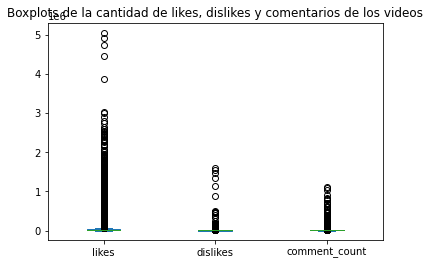

In [12]:
dataframeCA.loc[:,["likes","dislikes","comment_count"]].plot.box()
plt.title("Boxplots de la cantidad de likes, dislikes y comentarios de los videos" )
plt.show()

# Visualizar los datos
**Toda visualización deberá tener un título, una leyenda y de ser necesario, una
tabla de datos que complemente su entendimiento.**

**1. ¿Qué categorías de videos son las de mayor tendencia?**

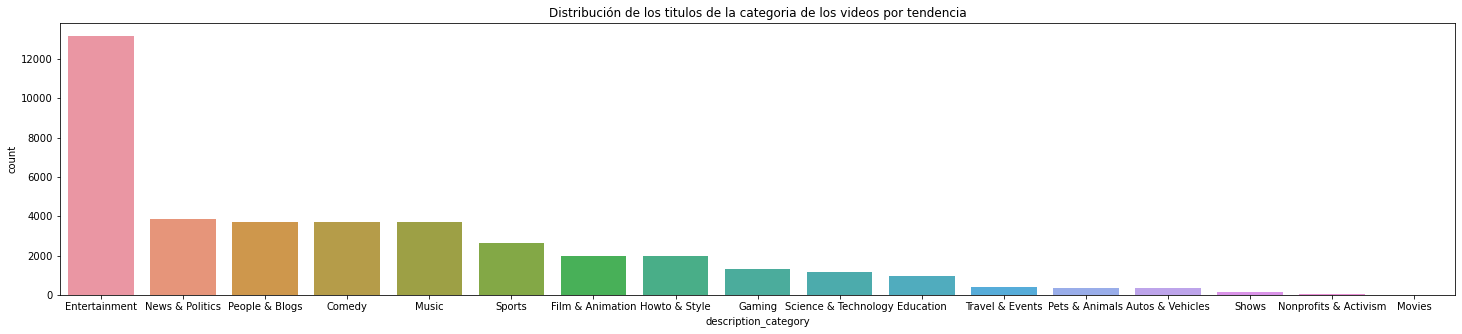

In [13]:
df=dataframeCA.groupby(["description_category"]).size().reset_index(name="count")
df=df.sort_values("count",ascending=False)
plt.figure(figsize=(25, 5))
plt.title("Distribución de los titulos de la categoria de los videos por tendencia" )
sns.barplot(x='description_category',y="count", data=df)
plt.show()

In [14]:
df

,description_category,count
3,Entertainment,13173
9,News & Politics,3868
11,People & Blogs,3726
1,Comedy,3725
8,Music,3695
15,Sports,2650
4,Film & Animation,2001
6,Howto & Style,1998
5,Gaming,1330
13,Science & Technology,1143


**2. ¿Qué categorías de videos son los que más gustan? ¿Y las que menos gustan?**

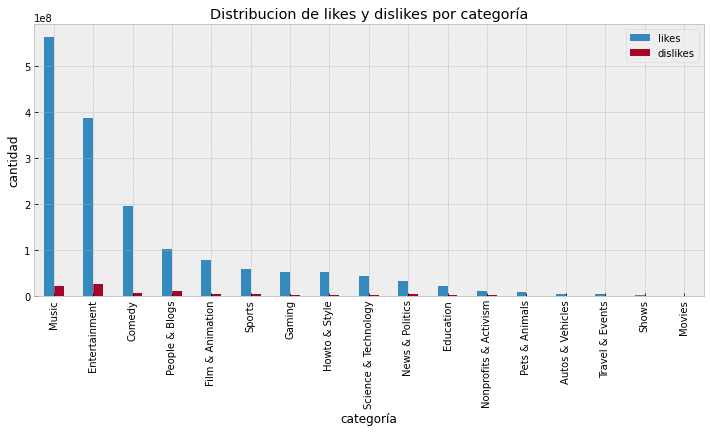

In [15]:
df_likes=dataframeCA.groupby(['description_category'])[['likes']].sum()
df_likes=df_likes.sort_values("likes",ascending=False)
df_dislikes=dataframeCA.groupby(['description_category'])[['dislikes']].sum()

df_result=pd.concat([df_likes, df_dislikes], axis=1)
plt.style.use('bmh')
df_result.plot.bar(title="Distribucion de likes y dislikes por categoría",figsize=(12,5),
            ylabel="cantidad",xlabel="categoría")

plt.show()

In [16]:
df_result.sort_values("dislikes",ascending=False)

,likes,dislikes
description_category,,
Entertainment,385612477,25660825
Music,562950999,22064769
People & Blogs,101413106,9296718
Comedy,194794035,5341733
Sports,58574334,3209078
News & Politics,32202728,3146614
Film & Animation,77693165,3104400
Gaming,51538080,2434569
Nonprofits & Activism,10199890,2324993


**3. ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Me gusta” / “No me gusta”?**

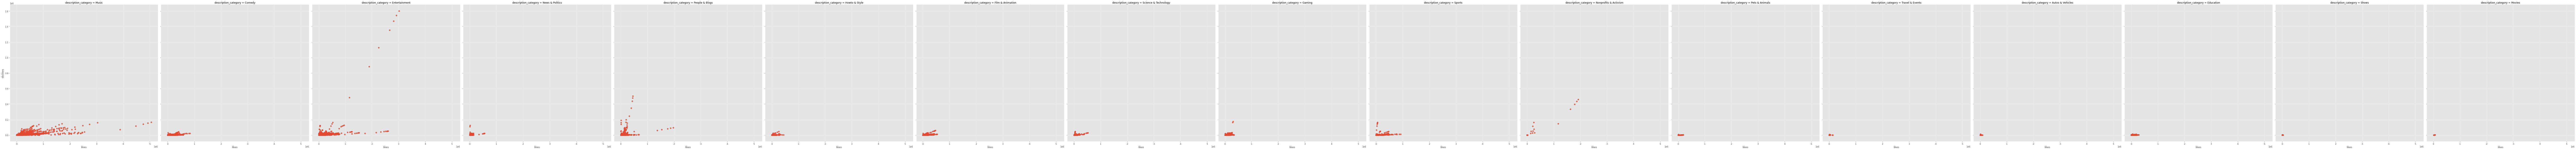

In [17]:
plt.style.use('ggplot')
sns.lmplot(x='likes',y='dislikes',data=dataframeCA,col='description_category',height=10,fit_reg=False)
plt.show()

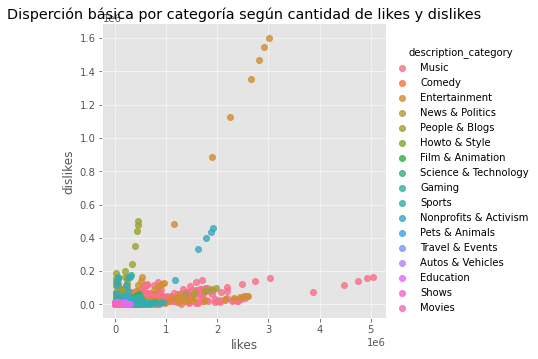

In [18]:
sns.lmplot(x='likes',y='dislikes',data=dataframeCA,hue='description_category',fit_reg=False)
plt.title("Disperción básica por categoría según cantidad de likes y dislikes" )
plt.show()

**4. ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Vistas” / “Comentarios”?**

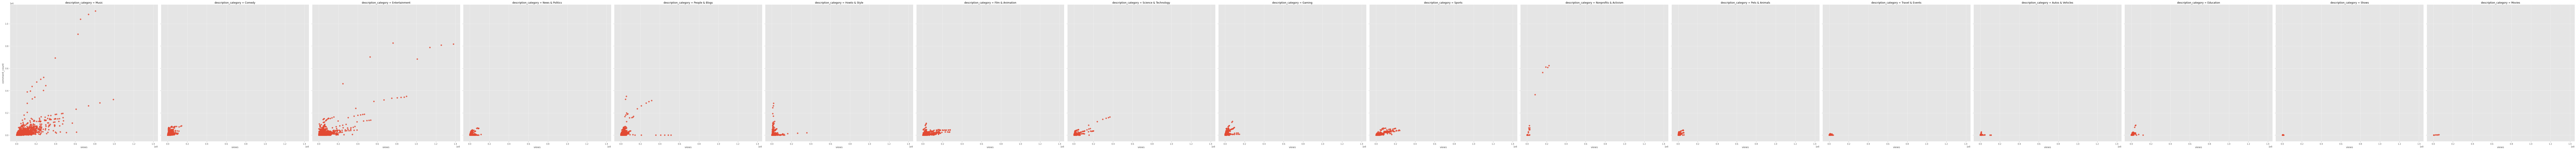

In [19]:
sns.lmplot(x='views',y='comment_count',data=dataframeCA,col='description_category',height=10,fit_reg=False)
plt.show()

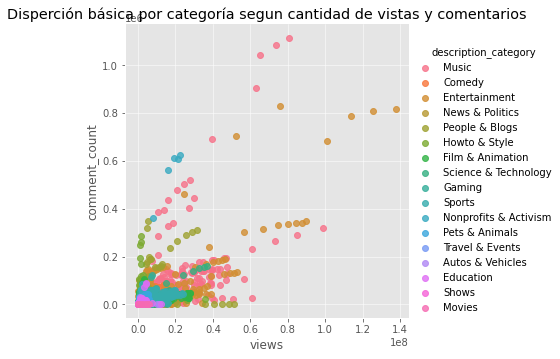

In [20]:
sns.lmplot(x='views',y='comment_count',data=dataframeCA,hue='description_category',fit_reg=False)
plt.title("Disperción básica por categoría segun cantidad de vistas y comentarios" )
plt.show()

**5. ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?**

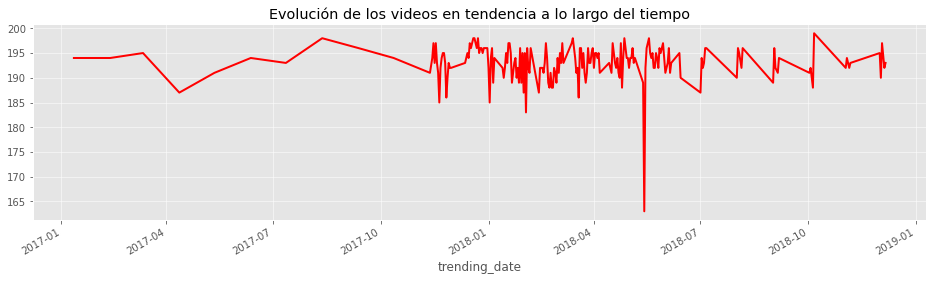

In [21]:
df=dataframeCA.groupby(["trending_date"]).size().reset_index(name="count")
df=df.sort_values("trending_date",ascending=False)

tdf = pd.Series(data=df['count'].values, index=df['trending_date'])
tdf.plot(figsize=(16,4), color='r', title="Evolución de los videos en tendencia a lo largo del tiempo");

In [22]:
df

,trending_date,count
204,2018-12-06,193
203,2018-12-05,192
202,2018-12-03,197
201,2018-12-02,190
200,2018-12-01,195
...,...,...
4,2017-05-12,191
3,2017-04-12,187
2,2017-03-12,195
1,2017-02-12,194


**6. ¿Qué Canales de YouTube son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?**

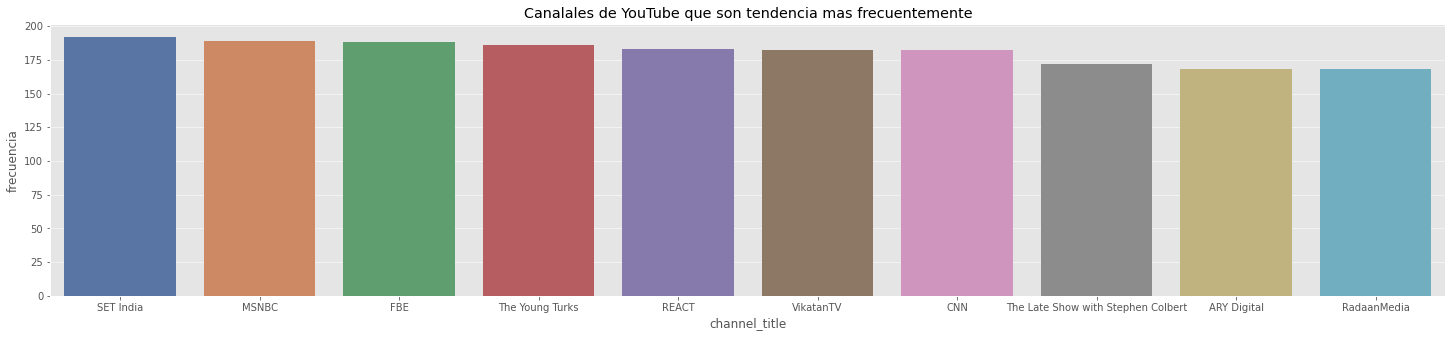

In [23]:
df=dataframeCA.groupby(["channel_title"]).size().reset_index(name="frecuencia")
df=df.sort_values("frecuencia",ascending=False)
df_may=df.head(10)
plt.figure(figsize=(25, 5))
plt.title("Canalales de YouTube que son tendencia mas frecuentemente" )
sns.barplot(x='channel_title',y="frecuencia", data=df_may ,palette='deep')
plt.show() 

In [24]:
df.head(5)

,channel_title,frecuencia
3095,SET India,192
2225,MSNBC,189
1169,FBE,188
3690,The Young Turks,186
2927,REACT,183


In [25]:
df.tail(5)

,channel_title,frecuencia
2267,Marie Claire,1
2265,Marcus Johns,1
2262,Marc Fitt Fr,1
2261,Marc Dupré,1
4772,활력소TV,1


**7. ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”?**

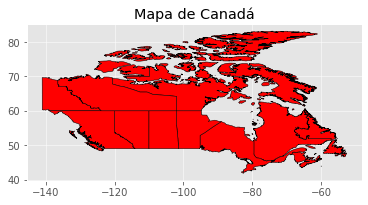

In [26]:
r = requests.get("https://raw.githubusercontent.com/Erick832/Canada/main/georef-canada-province.json")
r.raise_for_status()

data = r.json()
for d in data:
    d['geometry'] = shape(d['fields']['geo_shape'])
state=list()
for d in data:
    state.append(d['fields']['prov_name_en'])

gdf = gpd.GeoDataFrame(data).set_geometry('geometry')
gdf.plot(color="red",edgecolor="black")
plt.title("Mapa de Canadá")
plt.show()

In [27]:
gdf['state']=state
gdf.at[3,'state']='Newfoundland And Labrador'#correcion del nombre

df_views=dataframeCA.groupby(['state'])[['views']].sum()
gdf_views=gdf.merge(df_views,how='left',left_on='state',right_index=True)

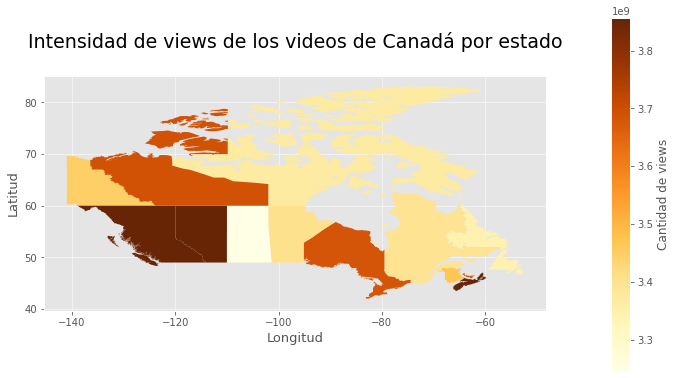

In [28]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
title = 'Intensidad de views de los videos de Canadá por estado'
plt.title(title + '\n', fontsize=19)
gdf_views.plot(column = 'views', cmap = 'YlOrBr',ax=ax)

ax.set_xlabel('Longitud', fontsize = 13)
ax.set_ylabel('Latitud', fontsize = 13)

min_p = min(gdf_views['views'])
max_p = max(gdf_views['views'])

bar = plt.cm.ScalarMappable(cmap='YlOrBr',
norm=plt.Normalize(vmin = min_p , vmax=max_p))

#Se declara una lista donde se guardarán los valores de la barra
bar._A = []
cax = plt.axes([1.00, 0.15, 0.03, 0.7]) #[xcoord, ycoord, ancho, largo]
# Impresión de la barra gráfica con las variables superiores (bar y cax)
cbar = fig.colorbar(bar, cax=cax)
cbar.set_label('Cantidad de views', fontsize = 12)

In [29]:
df=df_views.sort_values("views",ascending=False)
df

,views
state,
Nova Scotia,3856335841
British Columbia,3853586604
Alberta,3851814774
Northwest Territories,3690688489
Ontario,3682550609
Prince Edward Island,3672850678
New Brunswick,3469101073
Yukon,3447525858
Manitoba,3404276252


In [30]:
df_likes=dataframeCA.groupby(['state'])[['likes']].sum()
gdf_likes=gdf.merge(df_likes,how='left',left_on='state',right_index=True)

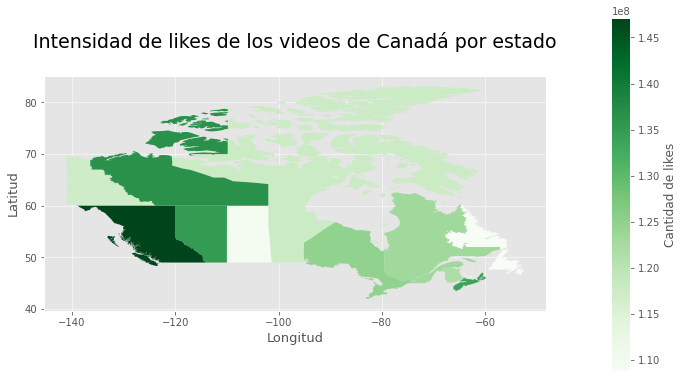

In [31]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
title = 'Intensidad de likes de los videos de Canadá por estado'
plt.title(title + '\n', fontsize=19)
gdf_likes.plot(column = 'likes', cmap = 'Greens',ax=ax)

ax.set_xlabel('Longitud', fontsize = 13)
ax.set_ylabel('Latitud', fontsize = 13)

min_p = min(gdf_likes['likes'])
max_p = max(gdf_likes['likes'])

bar = plt.cm.ScalarMappable(cmap='Greens',
norm=plt.Normalize(vmin = min_p , vmax=max_p))

#Se declara una lista donde se guardarán los valores de la barra
bar._A = []
cax = plt.axes([1.00, 0.15, 0.03, 0.7]) 

cbar = fig.colorbar(bar, cax=cax)
cbar.set_label('Cantidad de likes', fontsize = 12)

In [32]:
df=df_likes.sort_values("likes",ascending=False)
df

,likes
state,
British Columbia,147110449
Northwest Territories,136638219
Alberta,134910354
Nova Scotia,133693555
Ontario,124856852
Quebec,123292815
New Brunswick,121655482
Manitoba,117818126
Nunavut,117681262


In [33]:
df_dislikes=dataframeCA.groupby(['state'])[['dislikes']].sum()
gdf_dislikes=gdf.merge(df_dislikes,how='left',left_on='state',right_index=True)

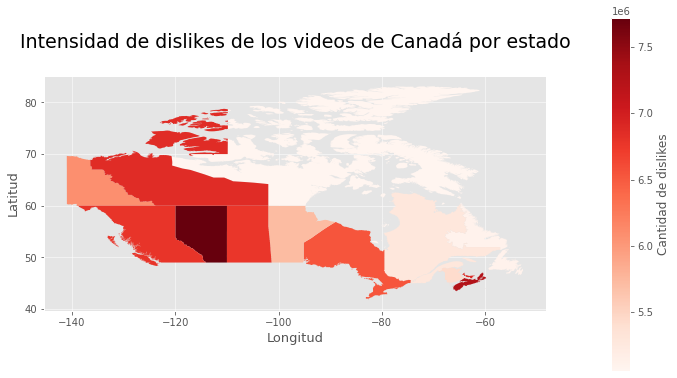

In [34]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
title = 'Intensidad de dislikes de los videos de Canadá por estado'
plt.title(title + '\n', fontsize=19)
gdf_dislikes.plot(column = 'dislikes', cmap = 'Reds',ax=ax)

ax.set_xlabel('Longitud', fontsize = 13)
ax.set_ylabel('Latitud', fontsize = 13)

min_p = min(gdf_dislikes['dislikes'])
max_p = max(gdf_dislikes['dislikes'])

bar = plt.cm.ScalarMappable(cmap='Reds',
norm=plt.Normalize(vmin = min_p , vmax=max_p))

#Se declara una lista donde se guardarán los valores de la barra
bar._A = []
cax = plt.axes([1.00, 0.15, 0.03, 0.7]) 

cbar = fig.colorbar(bar, cax=cax)
cbar.set_label('Cantidad de dislikes', fontsize = 12)

In [35]:
df=df_dislikes.sort_values("dislikes",ascending=False)
df

,dislikes
state,
Alberta,7719223
Nova Scotia,7262751
Prince Edward Island,6891081
Northwest Territories,6863719
British Columbia,6783569
Saskatchewan,6770597
Ontario,6542266
Yukon,6081053
Manitoba,5721698


**¿Es factible predecir el número de “Vistas” o “Me gusta” o “No me gusta”?**

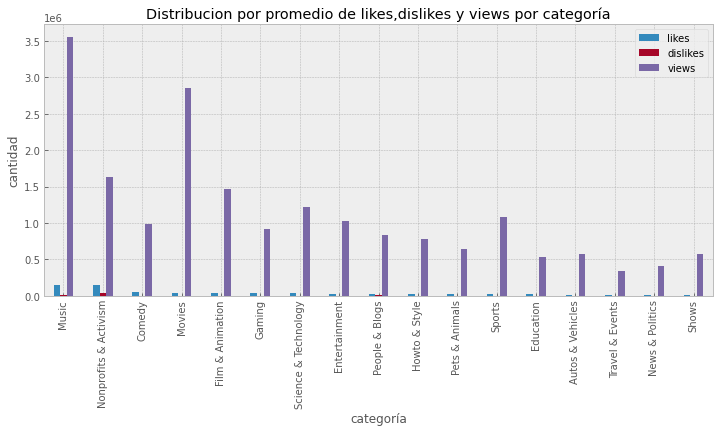

In [36]:
df_vistas=dataframeCA.groupby(['description_category'])[['views']].mean()
df_likes=dataframeCA.groupby(['description_category'])[['likes']].mean()
df_likes=df_likes.sort_values("likes",ascending=False)
df_dislikes=dataframeCA.groupby(['description_category'])[['dislikes']].mean()


df_result=pd.concat([df_likes, df_dislikes,df_vistas], axis=1)
plt.style.use('bmh')
df_result.plot.bar(title="Distribucion por promedio de likes,dislikes y views por categoría",figsize=(12,5),
            ylabel="cantidad",xlabel="categoría")

plt.show()

In [37]:
df_result

,likes,dislikes,views
description_category,,,
Music,152354.803518,5971.520704,3.556905e+06
Nonprofits & Activism,145712.714286,33214.185714,1.630603e+06
Comedy,52293.700671,1434.022282,9.891344e+05
Movies,42150.833333,2046.666667,2.853415e+06
Film & Animation,38827.168916,1551.424288,1.459745e+06
Gaming,38750.436090,1830.503008,9.222066e+05
Science & Technology,36757.263342,1545.007874,1.216360e+06
Entertainment,29272.942914,1947.986412,1.027834e+06
People & Blogs,27217.688137,2495.093398,8.273183e+05


**¿Los videos en tendencia son los que mayor cantidad de comentarios positivos reciben?**

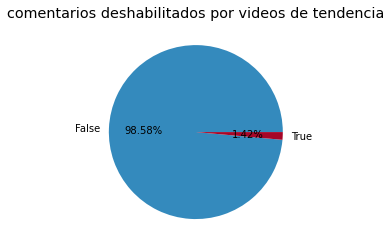

In [38]:
df=dataframeCA.groupby(["comments_disabled"]).size().reset_index(name="count")
plt.pie(x='count', labels="comments_disabled",data=df,autopct='%1.2f%%')
plt.title('comentarios deshabilitados por videos de tendencia')
plt.show()

In [39]:
df

,comments_disabled,count
0,False,39023
1,True,562


# MODELIZAR Y EVALUAR LOS DATOS 

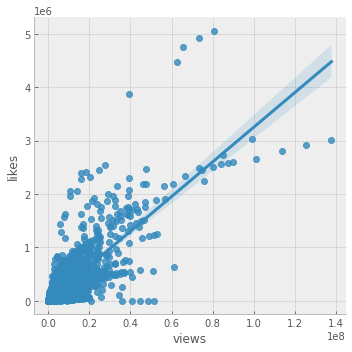

In [40]:
sns.lmplot(x='views',y='likes',data=dataframeCA,palette='Accent')
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [42]:
X=dataframeCA[['comment_count','views','dislikes']]
y=dataframeCA['likes']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [44]:
lm = LinearRegression()

In [45]:
lm.fit(X_train,y_train)

LinearRegression()

In [46]:
slope = lm.coef_  # w1
intercept = lm.intercept_ # w0

print("Las pendientes 'w1' del modelo son: ", slope)
print("El término independiente de la recta 'w0' es: ", intercept)

Las pendientes 'w1' del modelo son:  [ 3.50539123  0.02281303 -1.60897603]
El término independiente de la recta 'w0' es:  -632.9496867692869


In [47]:
coef_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coeficiente'])
coef_df

,Coeficiente
comment_count,3.505391
views,0.022813
dislikes,-1.608976


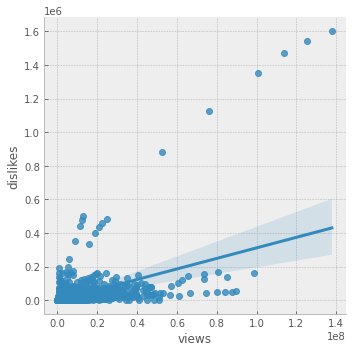

In [48]:
sns.lmplot(x='views',y='dislikes',data=dataframeCA,palette='Accent')
plt.show()

In [49]:
X=dataframeCA[['comment_count','views','likes']]
y=dataframeCA['dislikes']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [51]:
slope = lm.coef_  # w1
intercept = lm.intercept_ # w0

print("Las pendientes 'w1' del modelo son: ", slope)
print("El término independiente de la recta 'w0' es: ", intercept)

Las pendientes 'w1' del modelo son:  [ 0.75463469  0.00317509 -0.10151782]
El término independiente de la recta 'w0' es:  -1379.5536439546659


In [52]:
coef_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coeficiente'])
coef_df

,Coeficiente
comment_count,0.754635
views,0.003175
likes,-0.101518


In [53]:
X=dataframeCA[['dislikes','likes']]
y=dataframeCA['views']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [55]:
slope = lm.coef_  # w1
intercept = lm.intercept_ # w0

print("Las pendientes 'w1' del modelo son: ", slope)
print("El término independiente de la recta 'w0' es: ", intercept)

Las pendientes 'w1' del modelo son:  [35.6180556  18.98669793]
El término independiente de la recta 'w0' es:  314748.1193979358


In [56]:
coef_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coeficiente'])
coef_df

,Coeficiente
dislikes,35.618056
likes,18.986698


In [59]:
dataframeCA.to_excel('data limpio.xlsx',index=False)
dataframeCA.to_csv('data limpio.csv',index=False)